# LG3 Forecaster Visualization Demo

Randomly sample an input sequence and plot input vs prediction vs ground truth.

Timestamp,Capa_Cooling,MFR_068,Rop,Comp1 Hz_1,Comp1 Hz_0,Power,VAP_Entha,LIQ_Entha,cycle,Tcond,SCEEV_M,Tod,day_sin,day_cos,week_sin,week_cos

In [305]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# Make repo imports available
sys.path.append("/home/jeonchanwook/Documents/Github/TOTEM")

# Paths
DATA_DIR = "../data/forecasting/Tin488_Tout96_Lag3d_7d1d_14d"
FEATURE_NAMES_JSON = os.path.join(DATA_DIR, 'feature_names.json')
PROCESSED_CSV = "../data/processed/lg3_train.csv"
CHECKPOINT_DIR = "../saved_models/lg3/forecaster_checkpoints/lg3_Tin488_Tout96_Lag3d_7d1d_14d_seed2021"
FEATURE_NAME = "Power"  # change to any numeric column in PROCESSED_CSV
CUDA_ID = 0


In [306]:
def load_feature_index(processed_csv, feature_name):
    df = pd.read_csv(processed_csv, nrows=1)
    cols = [c for c in df.columns if c != "Timestamp"]
    if feature_name not in cols:
        raise ValueError(f"Feature '{feature_name}' not found. Available example: {cols[:10]}")
    return cols.index(feature_name), cols

def inference(
    x,
    y,
    codeids_x,
    model_decode,
    model_mustd,
    codebook,
    compression,
    device,
    onehot=False,
    scheme=1,
):
    x = x.to(device)
    codeids_x = codeids_x.to(device)

    bsz, tcin, sin = codeids_x.shape
    tout = y.shape[1]

    _ = model_mustd.revin_in(x, "norm")
    _ = model_mustd.revin_out(y.to(device), "norm")

    code_ids = codeids_x.flatten()
    if onehot:
        xcodes = torch.nn.functional.one_hot(code_ids, num_classes=codebook.shape[0])
    else:
        xcodes = codebook[code_ids]
    xcodes = xcodes.reshape((bsz, tcin, sin, xcodes.shape[-1]))
    xcodes = torch.permute(xcodes, (0, 2, 1, 3))
    xcodes = xcodes.reshape((bsz * sin, tcin, xcodes.shape[-1]))
    xcodes = torch.permute(xcodes, (1, 0, 2))

    ytime = model_decode(xcodes)
    ytime = ytime.reshape((bsz, sin, tout))
    ytime = torch.permute(ytime, (0, 2, 1))

    times = torch.permute(x, (0, 2, 1))
    times = times.reshape((-1, times.shape[-1]))
    ymeanstd = model_mustd(times)
    ymeanstd = ymeanstd.reshape((bsz, sin, 2))
    ymeanstd = torch.permute(ymeanstd, (0, 2, 1))
    ymean = ymeanstd[:, 0, :].unsqueeze(1)
    ystd = ymeanstd[:, 1, :].unsqueeze(1)

    if scheme == 1:
        ymean = ymean + model_mustd.revin_in.mean
        ystd = ystd + model_mustd.revin_in.stdev
        ytime = ytime * ystd + ymean
    elif scheme == 2:
        ytime = model_mustd.revin_in(ytime, "denorm")
    else:
        raise ValueError(f"Unknown prediction scheme {scheme}")

    return ytime.detach().cpu().numpy()


Sample index: 385
MSE: 35.3300  MAE: 5.0464  MAPE: 50463952000.0000%  MASE: 1.9641


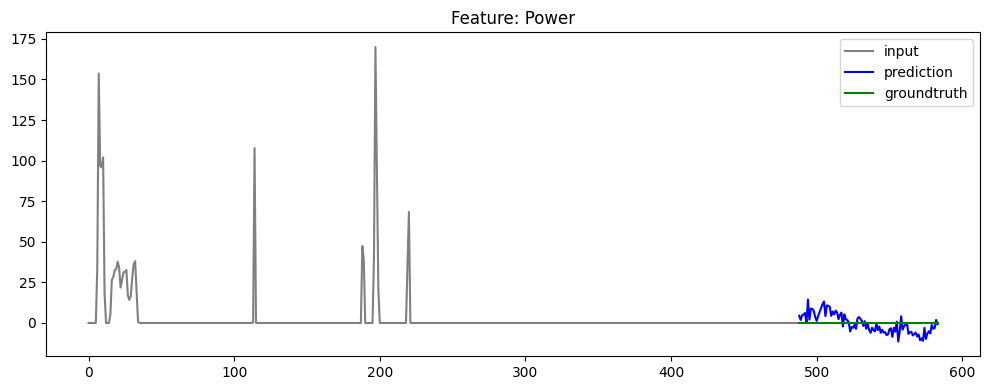

In [353]:
import json

if os.path.exists(FEATURE_NAMES_JSON):
    feature_names = json.load(open(FEATURE_NAMES_JSON))
    if FEATURE_NAME not in feature_names:
        raise ValueError(f"Feature '{FEATURE_NAME}' not found in feature_names.json")
    feature_idx = feature_names.index(FEATURE_NAME)
else:
    feature_idx, cols = load_feature_index(PROCESSED_CSV, FEATURE_NAME)


x = np.load(os.path.join(DATA_DIR, "test_x_original.npy"))
y = np.load(os.path.join(DATA_DIR, "test_y_original.npy"))
codeids_x = np.load(os.path.join(DATA_DIR, "test_x_codes.npy"))
codebook = np.load(os.path.join(DATA_DIR, "codebook.npy"))

sample_idx = np.random.randint(0, len(x))
print("Sample index:", sample_idx)

x_sample = torch.from_numpy(x[sample_idx : sample_idx + 1]).float()
y_sample = torch.from_numpy(y[sample_idx : sample_idx + 1]).float()
code_x_sample = torch.from_numpy(codeids_x[sample_idx : sample_idx + 1]).long()

device = f"cuda:{CUDA_ID}" if torch.cuda.is_available() else "cpu"
model_decode = torch.load(
    os.path.join(CHECKPOINT_DIR, "decode_checkpoint.pth"),
    map_location=device,
    weights_only=False,
)
model_mustd = torch.load(
    os.path.join(CHECKPOINT_DIR, "mustd_checkpoint.pth"),
    map_location=device,
    weights_only=False,
)
model_decode.to(device).eval()
model_mustd.to(device).eval()

codebook_t = torch.from_numpy(codebook).to(device=device, dtype=torch.float32)

y_pred = inference(
    x_sample,
    y_sample,
    code_x_sample,
    model_decode,
    model_mustd,
    codebook_t,
    compression=4,
    device=device,
    scheme=1,
)

x_series = x_sample[0, :, feature_idx].numpy()
y_series = y_sample[0, :, feature_idx].numpy()
y_pred_series = y_pred[0, :, feature_idx]

mse = float(np.mean((y_pred_series - y_series) ** 2))
mae = float(np.mean(np.abs(y_pred_series - y_series)))
# MAPE (Mean Absolute Percentage Error) 계산
epsilon = 1e-8
mape = float(np.mean(np.abs((y_series - y_pred_series) / (y_series + epsilon)))) * 100
# MASE (Mean Absolute Scaled Error) 계산
# 스케일링을 위한 naive forecast의 MAE (여기서는 입력 시퀀스의 인접 값 차이 평균 사용)
# x_series는 모델의 입력 시퀀스이므로, 이를 "in-sample" 데이터로 간주하여 스케일링 팩터 계산
scale = np.mean(np.abs(x_series[1:] - x_series[:-1]))
if scale == 0: # Division by zero 방지
    mase = float('inf') if mae != 0 else 0.0
else:
   mase = mae / scale
print(f"MSE: {mse:.4f}  MAE: {mae:.4f}  MAPE: {mape:.4f}%  MASE: {mase:.4f}")

input_len = len(x_series)
pred_len = len(y_series)

x_axis_input = np.arange(0, input_len)
x_axis_pred = np.arange(input_len, input_len + pred_len)

plt.figure(figsize=(10, 4))
plt.plot(x_axis_input, x_series, color="gray", label="input")
plt.plot(x_axis_pred, y_pred_series, color="blue", label="prediction")
plt.plot(x_axis_pred, y_series, color="green", label="groundtruth")
plt.legend()
plt.title(f"Feature: {FEATURE_NAME}")
plt.tight_layout()
plt.show()